In [1]:
import numpy as np
import os
import tensorflow as tf
import pandas as pd
import PIL
import math
from keras.applications.vgg19 import VGG19
from keras.applications.vgg16 import VGG16
from keras.applications.densenet import DenseNet169
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.nasnet import NASNetMobile
from keras.applications.resnet50 import ResNet50
from keras.applications.densenet import DenseNet
from keras.applications.xception import Xception
from joblib import Parallel, delayed
import gc
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras import optimizers, losses, activations, models
from keras.models import load_model
from keras.models import Sequential
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalMaxPool2D, Concatenate
import copy
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape
from keras.optimizers import SGD, RMSprop
from keras.utils import np_utils
from keras.regularizers import l2
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D, AveragePooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import multi_gpu_model
from IPython.display import clear_output

import h5py
from keras import callbacks
PIL.Image.MAX_IMAGE_PIXELS = 1000000000
import h5py
from keras.utils.io_utils import HDF5Matrix
import pickle
from keras.applications import mobilenet
from keras.callbacks import LambdaCallback
import time
import logging
import threading
import matplotlib.pyplot as plt
import Augmentor
from imgaug import augmenters as iaa
import smtplib
from email.mime.text import MIMEText
from email.mime.image import MIMEImage
from email.mime.multipart import MIMEMultipart
from keras.layers import GlobalAveragePooling2D

%matplotlib inline
def gen_warp(igen, iaug):
    while 1:
        A = next(igen)
        yield iaug.augment_images(A[0]*255)/255, A[1]
        
def SendMail(title, content):
    msg = MIMEMultipart()
    msg['Subject'] = title
    msg['From'] = 'ricciflowfinance@gmail.com'
    msg['To'] = 'cuixin.math@gmail.com'

    text = MIMEText(content)
    msg.attach(text)

    s = smtplib.SMTP('smtp.gmail.com',587)
    s.starttls()
    s.ehlo()
    s.login('ricciflowfinance@gmail.com', 'IloveRicciflow!')
    s.sendmail('ricciflowfinance@gmail.com', 'ricciflowfinance@gmail.com', msg.as_string())
    s.quit()

Using TensorFlow backend.


# Data set exploration

1. Training data set : /home/mathematics/kaggle/furniture/data/train/raw
2. Testing data set : /home/mathematics/kaggle/furniture/data/test/
3. Submission data set : /home/mathematics/kaggle/furniture/data/validation/
## structure of the file:

PATH/label/filename

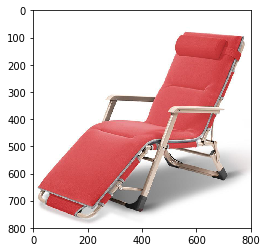

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(PIL.Image.open('/home/mathematics/kaggle/furniture/data/train/raw/0/89809.jpeg'))

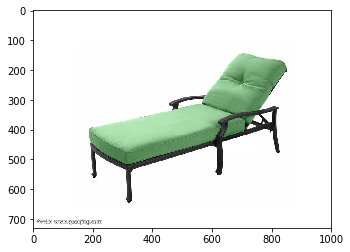

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(PIL.Image.open('/home/mathematics/kaggle/furniture/data/train/raw/0/89827.jpeg'))

# Augmentation

In [2]:
BUFFER_SIZE = 8192
PIC_SIZE = 299
'''        seq = iaa.Sequential([
            iaa.Fliplr(p = 0.5),
            iaa.CoarseDropout((0.0, 0.005), size_percent=(0.03, 0.05),per_channel = True),
            iaa.Add((-40, 40), per_channel=0.5)
        ])
'''

def func(ind, aug):
    pic = np.uint8(np.array(PIL.Image.open(ind[0])))
    label = np.uint8(np.zeros(128))
    label[ind[1]] = 1
    if aug:
        np.random.seed()

        seq = iaa.Sequential([
            iaa.Fliplr(0.5), # horizontal flips
            iaa.Crop(percent=(0, 0.1)), # random crops
            # Small gaussian blur with random sigma between 0 and 0.5.
            # But we only blur about 50% of all images.
            iaa.Sometimes(0.5,
                iaa.GaussianBlur(sigma=(0, 0.3))
            ),
            iaa.Sometimes(0.5,
                iaa.CoarseDropout((0.0, 0.005), size_percent=(0.03, 0.05),per_channel = True)
            ),
            # Strengthen or weaken the contrast in each image.
            iaa.ContrastNormalization((0.75, 1.5)),
            # Add gaussian noise.
            # For 50% of all images, we sample the noise once per pixel.
            # For the other 50% of all images, we sample the noise per pixel AND
            # channel. This can change the color (not only brightness) of the
            # pixels.
            iaa.AdditiveGaussianNoise(loc=0, scale=(0.0, 0.05*255), per_channel=0.5),
            # Make some images brighter and some darker.
            # In 20% of all cases, we sample the multiplier once per channel,
            # which can end up changing the color of the images.
            iaa.Multiply((0.8, 1.2), per_channel=0.2),
            # Apply affine transformations to each image.
            # Scale/zoom them, translate/move them, rotate them and shear them.
            iaa.Affine(
                scale={"x": (0.9, 1.1), "y": (0.9, 1.1)},
                translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)},
                rotate=(-10, 10),
                shear=(-6, 6)
            ),
            
        ], random_order=True)
        pic = seq.augment_image(pic)
    return pic,label


    

def image_gen(folder, batch_size, aug):
    path_label_list = []
    seed_num = 0
    
    np.random.seed()
    
    for subdir, dirs, files in os.walk(folder):
        for file in files:
            class_label = int(subdir.split('/')[-1])
            filepath = subdir + os.sep + file
            path_label_list.append((filepath,class_label))
    
    raw__list = list(range(len(path_label_list)))
    np.random.shuffle(raw__list)
    #finished_pics is total pics processed
    finished_pics = 0
    #we store a buffer in the memory
    buffer_batch_label_list = []
    buffer_batch_index_list = []
    #batch_start is the location to return at buffer_batch
    batch_start = 0    
    while True:
        np.random.seed()
        if batch_start == len(buffer_batch_index_list):
            if finished_pics >= len(raw__list):
                np.random.shuffle(raw__list)
                finished_pics = 0
                buffer_batch = []
                buffer_batch_index_list = []
            batch_start = 0
            buffer_batch_index_list = raw__list[finished_pics:min(len(raw__list),finished_pics + BUFFER_SIZE)]
            buffer_batch_label_list = []
            
            if len(buffer_batch_index_list) % batch_size != 0:
                append_num = batch_size - len(buffer_batch_index_list) % batch_size
                buffer_batch_index_list += list(np.random.choice(raw__list,append_num,replace = False))
            finished_pics += len(buffer_batch_index_list)
            for pic_index in buffer_batch_index_list:
                buffer_batch_label_list.append(path_label_list[pic_index])

            buffer = Parallel(n_jobs=8, verbose = 0)(delayed(func)(i, aug) for i in buffer_batch_label_list)

            if (len(buffer) != len(buffer_batch_index_list)):
                print(['Len of buffer is ', len(buffer)])
                print(['Len of buffer index list is ', len(buffer_batch_index_list)])
                print('ERROR!')
            x = []
            y = []
            for j in buffer:
                x.append(j[0])
                y.append(j[1])
            buffer = np.array(x), np.array(y)
        yield buffer[0][batch_start:batch_start+batch_size]/255, buffer[1][batch_start:batch_start+batch_size]/255
        batch_start += batch_size

In [29]:
test = image_gen('/home/mathematics/kaggle/furniture/data/train/299/', 16, aug = True)
x, y = next(test)

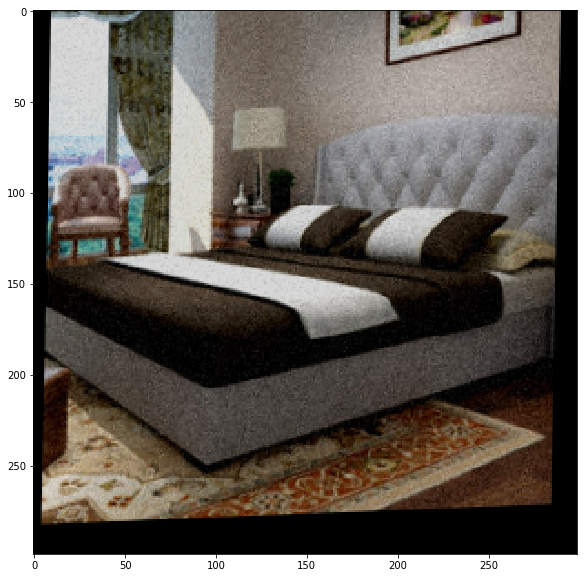

In [40]:
plt.figure(figsize = (10,10))
plt.imshow(x[12])

## Method 1: Transfer learning-fully connected layer

In [ ]:
from keras.utils import generic_utils
TRAIN_SIZE = 191552
TEST_SIZE = 6535
BATCH_SIZE = 32
PIC_SHAPE = 299
LR = 0.01
DR = 0.96

train_gen = image_gen('/home/mathematics/kaggle/furniture/data/train/299/', BATCH_SIZE, aug = True)
test_gen = image_gen('/home/mathematics/kaggle/furniture/data/validation/299/', BATCH_SIZE, aug = False)
#For inception ResNet V2 bottleneck feature 
'''model = load_model('/home/mathematics/kaggle/furniture/model/fully_connect_Inception_DenseNet/epoch-0-0.7448.h')'''

with tf.device('/cpu:0'):
    top_model = Sequential()
    top_model.add(Flatten(input_shape=(9, 9, 512)))
    top_model.add(Dense(4096, activation='relu'))
    top_model.add(Dense(4096, activation='relu'))
    top_model.add(Dense(128, activation='sigmoid'))     
    
    inp = Input(shape=(PIC_SHAPE, PIC_SHAPE,3))   
    norm_inp = BatchNormalization()(inp)
    raw_model = VGG19(include_top=False, weights='imagenet',input_shape = (299,299,3))(norm_inp)
    base_model = models.Model(inputs=inp, outputs=raw_model)
    base_model.layers[2].trainable = False
    
    combined_model = Model(inputs= base_model.input, outputs= top_model(base_model.output))
    

#multi_model = multi_gpu_model(model, 2)
OPT = optimizers.SGD(momentum = 0.9, lr = LR)

multi_model = multi_gpu_model(combined_model, 2)
multi_model.compile(loss='categorical_crossentropy', optimizer=OPT,metrics=['accuracy'])



for epoch in range(20):
    progbar = generic_utils.Progbar(TRAIN_SIZE)
    scores = ""
    for i in range(TRAIN_SIZE//BATCH_SIZE + 1):
        x_batch, y_batch = next(train_gen)
        #temp = base_model.predict_on_batch(x_batch)
        loss, acc = multi_model.train_on_batch(x_batch, y_batch)
        progbar.add(BATCH_SIZE, values=[("train loss", loss), ("acc", acc)])
        if (i % 100 == 90):
            scores = scores + ".%4f  ;"%(acc)
    acc_list = []
    
    progbar = generic_utils.Progbar(TEST_SIZE)
    for i in range(TEST_SIZE//BATCH_SIZE):
        x_batch, y_batch = next(test_gen)
        y_pred = multi_model.predict_on_batch(x_batch)
        acc = 0
        for i in range(BATCH_SIZE):
            if np.argmax(y_pred[i]) == np.argmax(y_batch[i]):
                acc += 1
        
        acc_list.append(acc / BATCH_SIZE)
        progbar.add(BATCH_SIZE, values=[("acc", np.mean(acc_list))])
    final_acc = np.mean(acc_list)
    name = "/home/mathematics/kaggle/furniture/model/VGG19_transfer/fully_connect/" +'epoch-' + str(epoch) + '-' +"%.4f" %(final_acc) + ".h"
    combined_model.save(name)
    SendMail('T score: .%4f'%(final_acc), scores)

189248/191552 [============================>.] - ETA: 1:05 - train loss: 0.0051 - acc: 0.6501

## Generate submission (In progress)

In [ ]:
import os
from joblib import Parallel, delayed
import itertools
import numpy as np
import pandas as pd
sub_csv = pd.read_csv(r'/home/mathematics/kaggle/furniture/data/sample_submission_randomlabel.csv')
sb = submission(['/home/mathematics/kaggle/furniture/model/0316/nInceptionResNetV2-2991116-0.803.hdf5',
                '/home/mathematics/kaggle/furniture/model/0316/nDenseNet169-2991115-0.771.hdf5',
                 '/home/mathematics/kaggle/furniture/model/0315/nXception-2991115.hdf5'],
           sub_csv,'/home/mathematics/kaggle/furniture/data/test/299/')
res = sb.predict()
res.to_csv('/home/mathematics/kaggle/furniture/data/2312.csv',index=False)